##### train2 LSTM_best.ipynb
- layer3 b50 -> 2차_공휴일 feature.csv -> 01.18스태킹.csv

- LSTM_best+holidy모델(최고성능)그대로 사용하고, train2만 추가.

- train2_LSTM_best+holiday.ipynb 파일 수정해서 사용





In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd

from datetime import datetime
from datetime import date, timedelta
from sklearn.model_selection import train_test_split

from matplotlib import pyplot
import matplotlib.pyplot as plt

#### train

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/DACON CUP'


# 1차:  2018년 9월 9일 ~ 2020년 11월 8일

train1 = pd.read_csv(path + '/open_data/train.csv', encoding = 'euc-kr')
train1.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2018-09-09 00:00:00,19,19,8,206
1,2018-09-09 01:00:00,20,19,9,259
2,2018-09-09 02:00:00,12,9,1,48
3,2018-09-09 03:00:00,10,10,2,102
4,2018-09-09 04:00:00,6,5,3,18


In [ ]:
train1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19008 entries, 0 to 19007
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   DateTime  19008 non-null  object
 1   사용자       19008 non-null  int64 
 2   세션        19008 non-null  int64 
 3   신규방문자     19008 non-null  int64 
 4   페이지뷰      19008 non-null  int64 
dtypes: int64(4), object(1)
memory usage: 742.6+ KB


In [ ]:
# 2차데이터 20년 11월 9일 ~ 12월 8일
#720행

train2 = pd.read_csv(path + '/open_data/2차_open_data/2차_train.csv', encoding='euc-kr')
train2.head()


,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-11-09 00:00:00,134,147,33,4082
1,2020-11-09 01:00:00,88,77,22,2444
2,2020-11-09 02:00:00,54,48,12,1148
3,2020-11-09 03:00:00,35,31,3,557
4,2020-11-09 04:00:00,31,34,7,711


In [ ]:
train_df = pd.concat([train1, train2])
train_df.shape

(19728, 5)

In [ ]:
# date 기준으로.

train_df['DateTime'] = pd.to_datetime(train_df.DateTime) #dtype: datetime으로 변경
train_df['date'] = train_df.DateTime.dt.date
train_df  = train_df.groupby('date').sum().reset_index()
train_df.head()

,date,사용자,세션,신규방문자,페이지뷰
0,2018-09-09,281,266,73,1826
1,2018-09-10,264,247,51,2092
2,2018-09-11,329,310,58,1998
3,2018-09-12,300,287,45,2595
4,2018-09-13,378,344,50,3845


In [ ]:
# date 기준 변수 만들기



def create_features(df):
    """
    Creates time series features from datetime index
    """
    # df['DateTime'] = df.index
    # df['hour'] = df['date'].dt.hour
    df['dayofweek'] = pd.to_datetime(df['date']).dt.dayofweek #요일
    df['quarter'] = pd.to_datetime(df['date']).dt.quarter 
    df['month'] = pd.to_datetime(df['date']).dt.month
    df['year'] = pd.to_datetime(df['date']).dt.year # 날짜의 해당 연도 시작에서부터의 일 수를 반환 
    df['dayofyear'] = pd.to_datetime(df['date']).dt.dayofyear
    df['dayofmonth'] = pd.to_datetime(df['date']).dt.day
    df['weekofyear'] = pd.to_datetime(df['date']).dt.weekofyear
    
    X = df[['사용자','세션','신규방문자','페이지뷰','date','dayofweek','quarter','month','year' #]]
           ,'dayofyear','dayofmonth','weekofyear']]
    X.set_index('date', inplace = True)
    X.index = pd.to_datetime(X.index)
    
    #X['date'] = pd.to_datetime(X['date']).dt.date
    
    return X

In [ ]:
train = create_features(train_df)
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


,사용자,세션,신규방문자,페이지뷰,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,
2018-09-09,281,266,73,1826,6,3,9,2018,252,9,36
2018-09-10,264,247,51,2092,0,3,9,2018,253,10,37
2018-09-11,329,310,58,1998,1,3,9,2018,254,11,37
2018-09-12,300,287,45,2595,2,3,9,2018,255,12,37
2018-09-13,378,344,50,3845,3,3,9,2018,256,13,37


In [ ]:
train.shape

(822, 11)

In [ ]:
# len(train['dayofyear'].unique())

#### 공휴일

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/DACON CUP'

holidays = pd.read_csv(path + '/open_data/holidays.csv', encoding = 'euc-kr', index_col=0)
holidays.set_index('date', inplace = True)
holidays.index = pd.to_datetime(holidays.index)
holidays.head()

,name
date,
2018-01-01,1월1일
2018-02-15,설날
2018-02-16,설날
2018-02-17,설날
2018-03-01,삼일절


- 공휴일에 1 or 0을 넣어서 피쳐추가.
    --> 결과가 좋지 않음

In [ ]:
holidays['holiday']=1
holidays.head()

,name,holiday
date,,
2018-01-01,1월1일,1
2018-02-15,설날,1
2018-02-16,설날,1
2018-02-17,설날,1
2018-03-01,삼일절,1


In [ ]:
train.insert(4, 'holiday', holidays['holiday'])
train = train.fillna(0)
len(train[train['holiday']==1])

42

In [ ]:
# 페이지뷰: 홈페이지에 들어온 접속자가 둘러 본 페이지수. 
# PV/UV : 한 사용자가 둘러본 페이지 수.

#train['PV/UV'] = train['페이지뷰']/train['사용자']
#train['PV/UV'] 

In [ ]:
train.head()

,사용자,세션,신규방문자,페이지뷰,holiday,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,,
2018-09-09,281,266,73,1826,0.0,6,3,9,2018,252,9,36
2018-09-10,264,247,51,2092,0.0,0,3,9,2018,253,10,37
2018-09-11,329,310,58,1998,0.0,1,3,9,2018,254,11,37
2018-09-12,300,287,45,2595,0.0,2,3,9,2018,255,12,37
2018-09-13,378,344,50,3845,0.0,3,3,9,2018,256,13,37


In [ ]:
for i, value in enumerate(train['holiday']):
  if value==1:
#    train['사용자'][i]= train['사용자'][i] - (train['사용자'][i]*0.1)
#    train['세션'][i]= train['세션'][i] - (train['세션'][i]*0.1)
#    train['신규방문자'][i]= train['신규방문자'][i] - (train['신규방문자'][i]*0.1)
    train['페이지뷰'][i]= train['페이지뷰'][i] - (train['페이지뷰'][i]*0.1)  

#train = train.drop(['holiday','PV/UV'],axis=1)
train = train.drop(['holiday'],axis=1)
train.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,사용자,세션,신규방문자,페이지뷰,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear
date,,,,,,,,,,,
2018-09-09,281,266,73,1826,6,3,9,2018,252,9,36
2018-09-10,264,247,51,2092,0,3,9,2018,253,10,37
2018-09-11,329,310,58,1998,1,3,9,2018,254,11,37
2018-09-12,300,287,45,2595,2,3,9,2018,255,12,37
2018-09-13,378,344,50,3845,3,3,9,2018,256,13,37


In [ ]:
# train['사용자'][1]*0.01

In [ ]:
"""for i, value in enumerate(train['holiday']):
  if value == '1월1일':
    train['사용자'][i]= train['사용자'][i] - (train['사용자'][i]*0.5)
    train['세션'][i]= train['세션'][i] - (train['세션'][i]*0.5)
    train['신규방문자'][i]= train['신규방문자'][i] - (train['신규방문자'][i]*0.5)
    train['페이지뷰'][i]= train['페이지뷰'][i] - (train['페이지뷰'][i]*0.5)  

  # 공휴일이면 페이지뷰 감소
  elif value!=0:
#    train['사용자'][i]= train['사용자'][i] - (train['사용자'][i]*0.1)
#    train['세션'][i]= train['세션'][i] - (train['세션'][i]*0.1)
#    train['신규방문자'][i]= train['신규방문자'][i] - (train['신규방문자'][i]*0.1)
    train['페이지뷰'][i]= train['페이지뷰'][i] - (train['페이지뷰'][i]*0.1)  

#train = train.drop(['holiday','PV/UV'],axis=1)
train = train.drop(['holiday'],axis=1)
train.head()"""

"for i, value in enumerate(train['holiday']):\n  if value == '1월1일':\n    train['사용자'][i]= train['사용자'][i] - (train['사용자'][i]*0.5)\n    train['세션'][i]= train['세션'][i] - (train['세션'][i]*0.5)\n    train['신규방문자'][i]= train['신규방문자'][i] - (train['신규방문자'][i]*0.5)\n    train['페이지뷰'][i]= train['페이지뷰'][i] - (train['페이지뷰'][i]*0.5)  \n\n  # 공휴일이면 페이지뷰 감소\n  elif value!=0:\n#    train['사용자'][i]= train['사용자'][i] - (train['사용자'][i]*0.1)\n#    train['세션'][i]= train['세션'][i] - (train['세션'][i]*0.1)\n#    train['신규방문자'][i]= train['신규방문자'][i] - (train['신규방문자'][i]*0.1)\n    train['페이지뷰'][i]= train['페이지뷰'][i] - (train['페이지뷰'][i]*0.1)  \n\n#train = train.drop(['holiday','PV/UV'],axis=1)\ntrain = train.drop(['holiday'],axis=1)\ntrain.head()"

#### 범주형 인코딩

- one-hot 인코딩: 카테고리가 별로 없는거
- binary 인코딩: 카테고리가 많은 거

In [ ]:
pip install category_encoders

In [ ]:
import category_encoders as ce

In [ ]:
# bianry encoding

# dayofyear	dayofmonth	weekofyear

encoder = ce.BinaryEncoder(cols=['dayofyear'])
train = encoder.fit_transform(train)

encoder = ce.BinaryEncoder(cols=['dayofmonth'])
train = encoder.fit_transform(train)

encoder = ce.BinaryEncoder(cols=['weekofyear'])
train = encoder.fit_transform(train)

print(train.shape)
# train.head(3)

(822, 31)


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):
/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [ ]:
# one-hot encoding

def dummy_data(data, columns):
    for column in columns:
        data = pd.concat([data, pd.get_dummies(data[column], prefix = column)], axis=1)
        data = data.drop(column, axis=1)
    return data


dummy_columns = ["dayofweek", "quarter", "month", "year"]
train = dummy_data(train,dummy_columns)

print(train.shape)
train.head(3)

(822, 53)


,사용자,세션,신규방문자,페이지뷰,dayofyear_0,dayofyear_1,dayofyear_2,dayofyear_3,dayofyear_4,dayofyear_5,dayofyear_6,dayofyear_7,dayofyear_8,dayofyear_9,dayofmonth_0,dayofmonth_1,dayofmonth_2,dayofmonth_3,dayofmonth_4,dayofmonth_5,weekofyear_0,weekofyear_1,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,quarter_1,quarter_2,quarter_3,quarter_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2018,year_2019,year_2020
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-09,281,266,73,1826,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-10,264,247,51,2092,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-11,329,310,58,1998,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


#### 데이터 전처리

In [ ]:
# scaling

mini = train.iloc[:,:4].min()
size = train.iloc[:,:4].max() - train.iloc[:,:4].min()
train.iloc[:,:4] = (train.iloc[:,:4] -  mini) / size
train.head()

,사용자,세션,신규방문자,페이지뷰,dayofyear_0,dayofyear_1,dayofyear_2,dayofyear_3,dayofyear_4,dayofyear_5,dayofyear_6,dayofyear_7,dayofyear_8,dayofyear_9,dayofmonth_0,dayofmonth_1,dayofmonth_2,dayofmonth_3,dayofmonth_4,dayofmonth_5,weekofyear_0,weekofyear_1,weekofyear_2,weekofyear_3,weekofyear_4,weekofyear_5,weekofyear_6,dayofweek_0,dayofweek_1,dayofweek_2,dayofweek_3,dayofweek_4,dayofweek_5,dayofweek_6,quarter_1,quarter_2,quarter_3,quarter_4,month_1,month_2,month_3,month_4,month_5,month_6,month_7,month_8,month_9,month_10,month_11,month_12,year_2018,year_2019,year_2020
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2018-09-09,0.051689,0.049083,0.042604,0.011741,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-10,0.048551,0.045564,0.029586,0.013453,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-11,0.060550,0.057233,0.033728,0.012848,0,0,0,0,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-12,0.055197,0.052973,0.026036,0.016689,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0
2018-09-13,0.069596,0.063530,0.028994,0.024731,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0


In [ ]:
# scaling

input_window = 61
output_window = 61 # 7

window_x = np.zeros((train.shape[0] - (input_window + output_window), input_window, 53))
window_y = np.zeros((train.shape[0] - (input_window + output_window), output_window, 4))

for start in range(train.shape[0] - (input_window + output_window)):
    end = start + input_window    
    window_x[start,:, :] = train.iloc[start : end                , : ].values
    window_y[start,:, :] = train.iloc[end   : end + output_window, :4 ].values


print('window_x.shape: ', window_x.shape)
print('window_y.shape: ', window_y.shape)

window_x.shape:  (700, 61, 53)
window_y.shape:  (700, 61, 4)


In [ ]:
# window_x

- 시계열 데이터 임베딩 찾아서 적용해보기
- 스케일링 다르게 해보기
- dropout 적용해보기

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, Sequential

from tensorflow.keras.layers import Dense, Conv1D, LSTM, Input, TimeDistributed
from tensorflow.keras.models import Model


optimizer = Adam, loss = mse, activation_function = 따로지정x

In [ ]:
tf.random.set_seed(40)


model = Sequential()
model.add(LSTM(32, input_shape=(61, 53), return_sequences=True))  # (timestep, features)
model.add(LSTM(32, return_sequences=True)) 
model.add(LSTM(32, return_sequences=True)) 
#model.add(LSTM(32, return_sequences=True)) 
#model.add(LSTM(32, return_sequences=True)) 
# model.add(LSTM(32, return_sequences=True)) 
model.add(TimeDistributed(Dense(4)))

model.summary()

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss='mean_squared_error', optimizer=opt)

model.fit(window_x, window_y, epochs=100, batch_size=50)


# layer3 b50 -> 1.2607e-04
# layer3 b55 ->  1.0079e-04
# layer3 b60 -> 1.3633e-04 추세는 비슷한데 값이 너무 낮음

# layer3 b30 -> 5.9194e-05 XX
# layer3 b40 -> 5.9194e-05 
# layer3 b45 -> 6.3832e-05 괜춘.
# layer3 b70 ->


# layer 4 b50 -> 1.3527e-04 페이지뷰 너무 낮음
# layer 4 b40 ->  9.5294e-05  xx
# layer 4 b30 -> 추세를 잘 예측하지 못함


# layer2 

# lstm2층 - epochs100, batch_size=10

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 61, 32)            11008     
_________________________________________________________________
lstm_10 (LSTM)               (None, 61, 32)            8320      
_________________________________________________________________
lstm_11 (LSTM)               (None, 61, 32)            8320      
_________________________________________________________________
time_distributed_3 (TimeDist (None, 61, 4)             132       
Total params: 27,780
Trainable params: 27,780
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
14/14 [==============================] - 5s 56ms/step - loss: 0.0436
Epoch 2/100
14/14 [==============================] - 1s 58ms/step - loss: 0.0112
Epoch 3/100
14/14 [==============================] - 1s 56ms/step - loss: 0.0085
Epoch

## test : last_df

In [ ]:
# train은 이미 위에서 minmax scaler적용되어있음.

last_df = train.iloc[-61:,:].values[np.newaxis,...] # np.newaxis: 3D로 차원을 늘려줌. 
last_df.shape

(1, 61, 53)

In [ ]:
pred_last = model.predict(last_df)
#pred_last

In [ ]:
pred_last = pred_last.reshape(output_window,4)
pred_last = pred_last * size[:4].values + mini[:4].values
pred_last = pred_last.astype(int)
pred_last


array([[  2186,   2147,    490,  53605],
       [  3065,   3035,    761,  71873],
       [  3682,   3573,    957, 101012],
       [  2105,   2018,    484,  49675],
       [  2007,   1956,    429,  47148],
       [  3382,   3325,    816,  89366],
       [  2937,   2868,    694,  77382],
       [  3437,   3379,    817,  91721],
       [  3312,   3262,    781,  80183],
       [  3155,   3145,    787,  75434],
       [  2046,   2065,    552,  45086],
       [  2108,   2155,    537,  50554],
       [  3697,   3743,   1040, 104187],
       [  2632,   2612,    602,  66276],
       [  2566,   2600,    636,  61461],
       [  2961,   3017,    829,  68332],
       [  2973,   3013,    837,  76922],
       [  1563,   1586,    437,  33327],
       [  1458,   1527,    405,  32977],
       [  2815,   2907,    773,  73740],
       [  2485,   2558,    688,  67564],
       [  2073,   2181,    580,  55033],
       [  2529,   2703,    724,  68668],
       [  2051,   2215,    632,  56342],
       [  1955, 

In [ ]:
pred_last.shape

(61, 4)

## submit

- submit 파일로드

In [ ]:
submission =  pd.read_csv(path + '/open_data/submission.csv', encoding = 'euc-kr')
submission= submission[30:]
submission.reset_index(drop=True,inplace=True)
submission.shape

(31, 5)

In [ ]:
pred_df = pd.DataFrame(pred_last)
pred_df = pred_df[:31]
pred_df.reset_index(drop=True, inplace = True)
pred_df.head()

,0,1,2,3
0,2186,2147,490,53605
1,3065,3035,761,71873
2,3682,3573,957,101012
3,2105,2018,484,49675
4,2007,1956,429,47148


In [ ]:

for i in range(len(submission)):
  submission['사용자'][i] = pred_df[0][i]
  submission['세션'][i] = pred_df[1][i]
  submission['신규방문자'][i] = pred_df[2][i]
  submission['페이지뷰'][i] = pred_df[3][i]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-

In [ ]:
submission.head()

,DateTime,사용자,세션,신규방문자,페이지뷰
0,2020-12-09,2186,2147,490,53605
1,2020-12-10,3065,3035,761,71873
2,2020-12-11,3682,3573,957,101012
3,2020-12-12,2105,2018,484,49675
4,2020-12-13,2007,1956,429,47148


In [ ]:
submission.to_csv('2차_공휴일 feature.csv', index = False, encoding = 'euc-kr')

#### 결과 제일 좋았던, 나빴던 파일이랑 predict를 비교

In [ ]:
submission.set_index('DateTime', inplace = True)
submission.index = pd.to_datetime(submission.index)
# submission.head()

In [ ]:
path2 = "/content/drive/MyDrive/Colab Notebooks/DACONCUP 주희"

In [ ]:
# 2차데이터 
#20년 11월 9일 ~ 12월 8일


train2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/DACON CUP/' + '/open_data/2차_open_data/2차_train.csv', encoding='euc-kr')

# date 기준으로.
train2['DateTime'] = pd.to_datetime(train2.DateTime) #dtype: datetime으로 변경
train2['DateTime'] = train2.DateTime.dt.date
train2  = train2.groupby('DateTime').sum().reset_index()

train2.set_index('DateTime', inplace = True)
train2.index = pd.to_datetime(train2.index)

train2.head()

,사용자,세션,신규방문자,페이지뷰
DateTime,,,,
2020-11-09,4364,4340,1143,95408
2020-11-10,4370,4256,1137,99623
2020-11-11,4492,4449,1071,114438
2020-11-12,3998,3899,796,94730
2020-11-13,4130,3967,835,101484


In [ ]:
best = pd.read_csv(path + '/submit_data/best공휴일+xgb_new.csv', encoding = 'euc-kr')
best = best.iloc[30:]
best.set_index('DateTime', inplace = True)
best.index = pd.to_datetime(best.index)


# lstm
lstm_sub_best = pd.read_csv(path + '/submit_data/공휴일 feature.csv', encoding = 'euc-kr')
#lstm_sub_best = pd.read_csv(path2 + '/best+holiday+1.1.csv', encoding = 'euc-kr')
lstm_sub_best = lstm_sub_best.iloc[30:]
lstm_sub_best.set_index('DateTime', inplace = True)
lstm_sub_best.index = pd.to_datetime(lstm_sub_best.index)


xgb_sub_best = pd.read_csv(path + '/submit_data/xgb_distribute_new.csv', encoding = 'euc-kr')
xgb_sub_best = xgb_sub_best.iloc[30:]
xgb_sub_best.set_index('DateTime', inplace = True)
xgb_sub_best.index = pd.to_datetime(xgb_sub_best.index)


In [ ]:
"""worst = pd.read_csv(path2+'/submit/seed40_add 날짜feature.csv', encoding = 'euc-kr')
# worst = pd.read_csv(path2 + '/submit/lstm5 e150 b10.csv', encoding = 'euc-kr')
worst.set_index('DateTime', inplace = True)
worst.index = pd.to_datetime(best.index)
#worst.head()"""

"worst = pd.read_csv(path2+'/submit/seed40_add 날짜feature.csv', encoding = 'euc-kr')\n# worst = pd.read_csv(path2 + '/submit/lstm5 e150 b10.csv', encoding = 'euc-kr')\nworst.set_index('DateTime', inplace = True)\nworst.index = pd.to_datetime(best.index)\n#worst.head()"

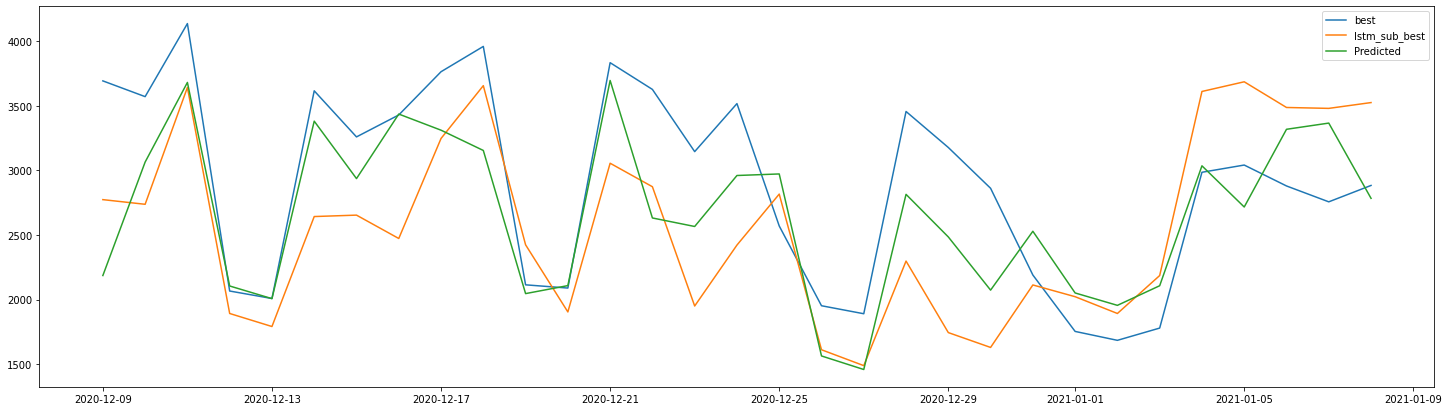

In [ ]:
# plot expected vs preducted


plt.figure(figsize = (25,7))
#pyplot.plot(train2['사용자'], label='best')
pyplot.plot(best['사용자'], label='best')
pyplot.plot(lstm_sub_best['사용자'], label='lstm_sub_best')
pyplot.plot(submission['사용자'], label='Predicted')
#pyplot.plot(xgb_sub_best['사용자'], label='xgb_sub_best')

#pyplot.plot(worst['사용자'], label = 'worst')
pyplot.legend()
pyplot.show()

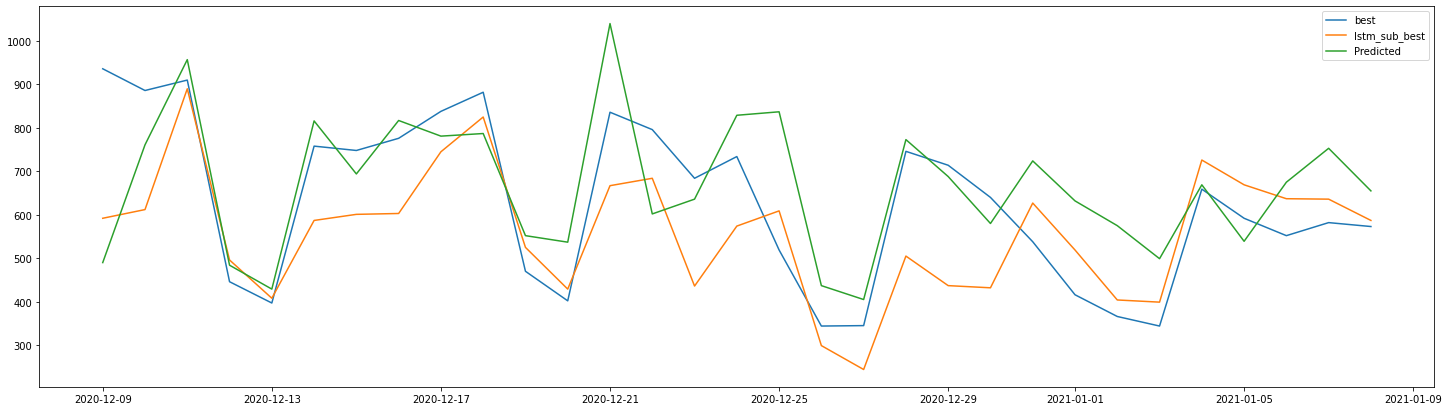

In [ ]:
plt.figure(figsize = (25,7))
pyplot.plot(best['신규방문자'], label='best')
pyplot.plot(lstm_sub_best['신규방문자'], label='lstm_sub_best')
pyplot.plot(submission['신규방문자'], label='Predicted')

#pyplot.plot(xgb_sub_best['신규방문자'], label='xgb_sub_best')

#pyplot.plot(worst['신규방문자'], label = 'worst')
pyplot.legend()
pyplot.show()

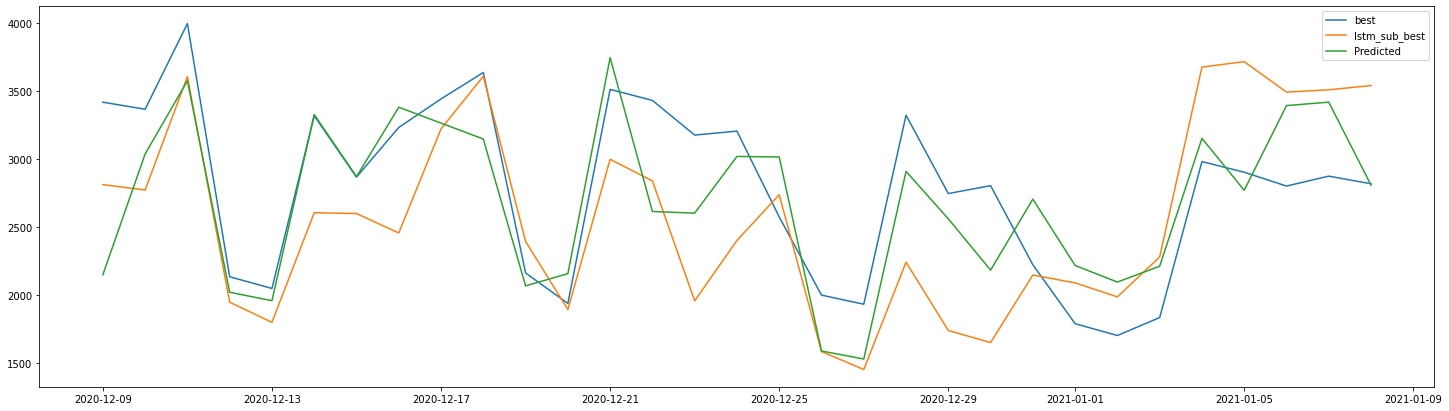

In [ ]:

plt.figure(figsize = (25,7))
pyplot.plot(best['세션'], label='best')
pyplot.plot(lstm_sub_best['세션'], label='lstm_sub_best')
pyplot.plot(submission['세션'], label='Predicted')

#pyplot.plot(xgb_sub_best['세션'], label='xgb_sub_best')

#pyplot.plot(worst['세션'], label = 'worst')
pyplot.legend()
pyplot.show()

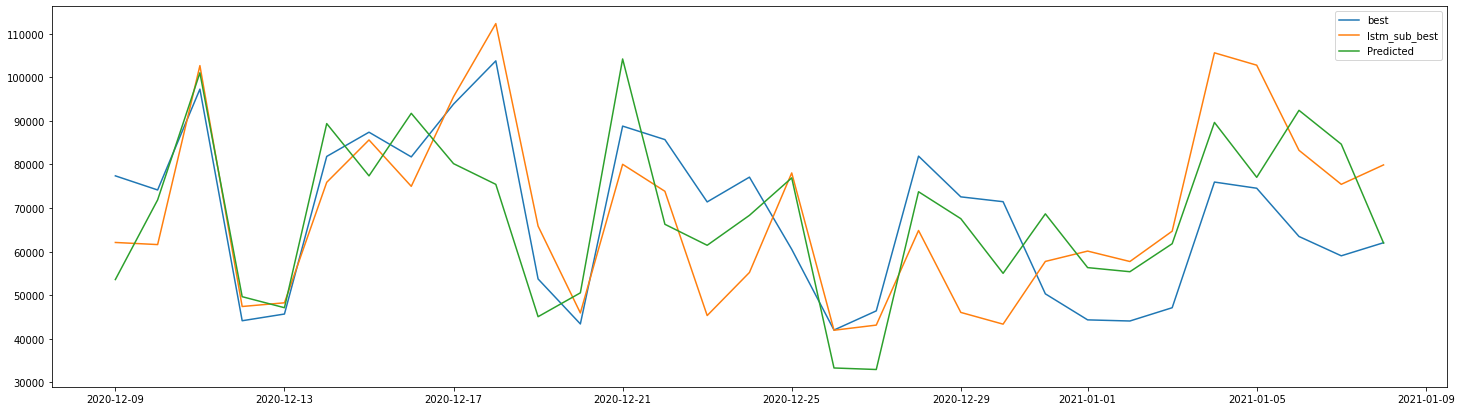

In [ ]:

plt.figure(figsize = (25,7))
pyplot.plot(best['페이지뷰'], label='best')
pyplot.plot(lstm_sub_best['페이지뷰'], label='lstm_sub_best')
pyplot.plot(submission['페이지뷰'], label='Predicted')

#pyplot.plot(xgb_sub_best['페이지뷰'], label='xgb_sub_best')
#pyplot.plot(worst['페이지뷰'], label = 'worst')
pyplot.legend()
pyplot.show()

- 위에 잘 예측하지 못하는 부분들은 조금 튀는 값인 것 같음
- 해당 일자에 어떤 특징(개최된 대회 등)을 파악
- 이후 1) 제거 또는 2) 특징 적용  (추세파악과 관련없다면 제거하기)